In [5]:
from Scripts import Trainings
from Scripts import Plotting
from Scripts import Computing_functions
import numpy as np
import timeit
import itertools
import importlib
import os
import glob
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import xarray as xr
import re
import seaborn as sns
import ast
import math
sns.set_context('paper') 
OcT = ['Ocean1', 'Ocean2', 'Ocean3', 'Ocean4']
Var_X_BIG_Extra = ['iceDraft', 'bathymetry', 'Slope_iceDraft_x', 'Slope_bathymetry_x',
                   'Slope_iceDraft_y', 'Slope_bathymetry_y', 'Big_T', 'Big_S',
                  'Distances_ground_line', 'Distances_front_line']
Var_X_BIG_Slope = ['iceDraft', 'bathymetry', 'Slope_iceDraft', 'Slope_bathymetry', 'Big_T', 'Big_S',
                  'Distances_ground_line', 'Distances_front_line']
Var_X_slopexy = ['iceDraft', 'bathymetry', 'Slope_iceDraft_x', 'Slope_bathymetry_x',
                   'Slope_iceDraft_y', 'Slope_bathymetry_y', 'temperatureYZ', 'salinityYZ',
                  'Distances_ground_line', 'Distances_front_line']

OcTPlus = ['Ocean1', 'Ocean2', 'Ocean3', 'Ocean4', 'CPL_EXP10_rst']
CPLs_test = ['CPL_EXP10_rst', 'CPL_EXP22_rst', 'CPL_EXP23_rst']

ALL_EXP = ['CPL_EXP10_rst','CPL_EXP11_rst', 'CPL_EXP12_rst','CPL_EXP13_rst','CPL_EXP20_rst','CPL_EXP21_rst','CPL_EXP22_rst', 'CPL_EXP23_rst']
Train_oc_exp = ['Ocean1', 'Ocean2', 'Ocean3', 'Ocean4', 'CPL_EXP10_rst','CPL_EXP13_rst', 'CPL_EXP22_rst', 'CPL_EXP23_rst']


NEW = ['IceOcean1r_ElmerIce', 'IceOcean1ra_ElmerIce']
NEW_under100supr = ['IceOcean1r_ElmerIce_under100supr', 'IceOcean1ra_ElmerIce_under100supr']
NEW_fill100 = ['IceOcean1r_ElmerIce_fill100', 'IceOcean1ra_ElmerIce_fill100']
importlib.reload(Plotting)
importlib.reload(Computing_functions)
importlib.reload(Trainings)


PWD : /home/bouissob/Code


<module 'Scripts.Trainings' from '/home/bouissob/Code/Scripts/Trainings.py'>

In [7]:
df = pd.DataFrame()
df['Test'] = range(90)

In [15]:
df = df.sample(frac = 0.2)

In [21]:
df.sort_index().head()

,Test
7,7
16,16
19,19
33,33
38,38


In [32]:
df.loc[df.index.isin([7, 6])]

,Test
7,7


In [29]:
df.iloc[7]

Test    33
Name: 33, dtype: int64

/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_32_N_32_32_96_96_Ch_0-1656189840_Ex_First_prune
/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_32_N_32_32_96_96_Ch_0-1656173410_Ex_First_prune
/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_32_N_32_32_96_96_Ch_0-1656185286_Ex_First_prune
/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_32_N_32_32_96_96_Ch_0-1656173420_Ex_First_prune
/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_32_N_32_32_96_96_Ch_0-1656177874_Ex_First_prune


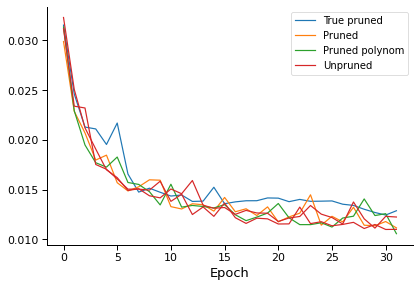

In [29]:
Mod = [{'Ocean' : OcT, 'Uniq_id' :  1656189840}, {'Ocean' : OcT, 'Uniq_id' :  1656173410}, 
       {'Ocean' : OcT, 'Uniq_id' : 1656185286} ,
       {'Ocean' : OcT, 'Uniq_id' : 1656173420}, {'Ocean' : OcT, 'Uniq_id':  1656177874},
      ]#{'Ocean' : OcT, 'Uniq_id' : 1653041657}]
Plotting.Plot_Loss_against_loss(Mods = Mod, Desired_comparaison=['val_mse'], save = False, Desired_length=64,
                                label = ['True pruned', 'Pruned', 'Pruned polynom' , 'Unpruned', 'Unpruned'])
#                label = ['No lr changes', 'Lr /5 every 8', 'Lr /2 every 10', 'lr plateau'])
#label = ['No lr changes', 'Lr /5 every 8', 'Lr /2 every 10', 'lr plateau']

In [10]:
1 - np.around(np.logspace(0, 1, 16, endpoint = False).astype(float), decimals=2)/10

array([0.9  , 0.885, 0.867, 0.846, 0.822, 0.795, 0.763, 0.726, 0.684,
       0.635, 0.578, 0.513, 0.438, 0.351, 0.25 , 0.134])

In [14]:
(1 - np.around(np.linspace(1, 10, 16, endpoint = False), decimals = 2) ** 2 / 100)[::-1]

array([0.108864, 0.211456, 0.309439, 0.399375, 0.483039, 0.561756,
       0.632764, 0.6975  , 0.755964, 0.808156, 0.854839, 0.894375,
       0.927639, 0.955056, 0.975664, 0.99    ])

In [14]:
importlib.reload(Plotting)
importlib.reload(Computing_functions)
importlib.reload(Trainings)

PWD : /home/bouissob/Code


<module 'Scripts.Trainings' from '/home/bouissob/Code/Scripts/Trainings.py'>

In [14]:
NN_attributes = {'Ocean' : OcT, 'Pruning' : True, 'Extra_n' : 'Prune_benchmark_ISOMIP'}
li = Computing_functions.Compute_general_benchmark(Var_to_bench='target_sparsity', 
            Ocean_target = OcT, NN_attributes=NN_attributes, message = False)

Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1656196107_Ex_Prune_benchmark_ISOMIP, ( 1 / 14)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1656199271_Ex_Prune_benchmark_ISOMIP, ( 2 / 14)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1656202354_Ex_Prune_benchmark_ISOMIP, ( 3 / 14)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1656205406_Ex_Prune_benchmark_ISOMIP, ( 4 / 14)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1656208454_Ex_Prune_benchmark_ISOMIP, ( 5 / 14)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4/Ep_64_N_128_128_128_128_128_Ch_0-1656211494_Ex_Prune_benchmark_ISOMIP, ( 6 / 14)
Model : /home/bouissob/Code/

In [15]:
li

([0.10886400000000007,
  0.21145599999999987,
  0.3094389999999998,
  0.39937500000000004,
  0.4830389999999999,
  0.5617559999999999,
  0.6327640000000001,
  0.6975,
  0.755964,
  0.808156,
  0.854839,
  0.894375,
  0.927639,
  0.955056],
 array([0.78315928, 0.55552703, 0.69856836, 0.09028847]),
 [0.31100575419414234,
  0.32606946433388523,
  0.3179573328676505,
  0.3413294890463412,
  0.35771416069448053,
  0.351657300049863,
  0.3668859100221776,
  0.3621135165067872,
  0.3971450228805684,
  0.3865177412624646,
  0.41599239967041346,
  0.4576605267172683,
  0.4781746475153181,
  0.5324090766694376])

In [3]:
Composite = ['Ocean1', 'Ocean2', 'Ocean3', 'Ocean4', 'CPL_EXP10_rst','CPL_EXP13_rst', 'CPL_EXP22_rst', 'CPL_EXP23_rst']
Ocean_tar = ['CPL_EXP11_rst', 'CPL_EXP12_rst']

In [ ]:
NN_attributes = {'Ocean' : Composite, 'Pruning' : True, 'Extra_n' : 'Prune_benchmark_Composite'}
li = Computing_functions.Compute_general_benchmark(Var_to_bench='target_sparsity', 
            Ocean_target = Ocean_tar, NN_attributes=NN_attributes, message = False)

Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_64_N_128_128_128_128_128_Ch_0-1656251884_Ex_Prune_benchmark_Composite, ( 1 / 17)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_64_N_128_128_128_128_128_Ch_0-1656257626_Ex_Prune_benchmark_Composite, ( 2 / 17)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_64_N_128_128_128_128_128_Ch_0-1656263189_Ex_Prune_benchmark_Composite, ( 3 / 17)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_64_N_128_128_128_128_128_Ch_0-1656315088_Ex_Prune_benchmark_Composite, ( 4 / 17)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP

In [31]:
li

([0.10886400000000007,
  0.21145599999999987,
  0.3094389999999998,
  0.10886400000000007,
  0.21145599999999987,
  0.3094389999999998],
 [array([9.04985956, 5.75312943]),
  array([14.49959684,  6.99669998]),
  array([14.02631611,  6.23662086]),
  array([13.88904444,  9.93929288]),
  array([8.78758289, 5.7674999 ]),
  array([10.78477635,  7.50120527])],
 [7.582824548090971,
  11.384026510041323,
  10.854330551556211,
  12.076735868421126,
  7.4325523278613534,
  9.2892271283883])

In [9]:
NN_attributes = {'Ocean' : Composite, 'Pruning' : True, 'Extra_n' : 'Prune_benchmark_Composite'}
Trainings.Get_model_path_json(**NN_attributes, return_all = True)

['/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_64_N_128_128_128_128_128_Ch_0-1656251884_Ex_Prune_benchmark_Composite',
 '/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_64_N_128_128_128_128_128_Ch_0-1656257626_Ex_Prune_benchmark_Composite',
 '/home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_64_N_128_128_128_128_128_Ch_0-1656263189_Ex_Prune_benchmark_Composite']

In [39]:
importlib.reload(Plotting)
importlib.reload(Computing_functions)
importlib.reload(Trainings)


PWD : /home/bouissob/Code


<module 'Scripts.Trainings' from '/home/bouissob/Code/Scripts/Trainings.py'>

In [28]:
NN_attributes = {'Ocean' : Composite, 'Pruning' : False, 'Extra_n' : 'Complexity_downgrade_composite'}
li = Computing_functions.Compute_general_benchmark(Var_to_bench='Neur_seq', 
            Ocean_target = Ocean_tar, NN_attributes=NN_attributes, message = False)

Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_64_N_96_96_96_96_96_Ch_0-1656318593_Ex_Complexity_downgrade_composite, ( 1 / 3)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_64_N_32_32_96_96_Ch_0-1656323971_Ex_Complexity_downgrade_composite, ( 2 / 3)
Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_64_N_96_96_96_96_96_Ch_0-1656330067_Ex_Complexity_downgrade_composite, ( 3 / 3)


In [32]:
import time
p = '/home/bouissob/Code/Cached_data/Generic_benchmark/'
Interest = 'Neur_seq'
pd.DataFrame.to_csv(li, p + f'{Interest}_{int(time.time())}.csv', index = False)

In [37]:
Composite_id = 1653216190
NN_attributes = {'Ocean' : Composite, 'Extra_n' : '', 'Uniq_id' : Composite_id}
li = Computing_functions.Compute_general_benchmark(Var_to_bench='Neur_seq', 
            Ocean_target = Ocean_tar, NN_attributes=NN_attributes, message = False)

Model : /home/bouissob/Code/Auto_model/COM_NEMO-CNRS/Ocean1_Ocean2_Ocean3_Ocean4_CPL_EXP10_rst_CPL_EXP13_rst_CPL_EXP22_rst_CPL_EXP23_rst/Ep_128_N_128_128_128_128_128_Ch_0-1653216190_Ex_, ( 1 / 1)


In [27]:
li

,Neur_seq,Overall_RMSE,CPL_EXP11_rst,CPL_EXP12_rst
0,128_128_128_128_128,12.021785,14.757393,8.441917


0.10886400000000007
Ep_64_N_128_128_128_128_128_Ch_0-1656251884_Ex_Prune_benchmark_Composite


<Figure size 432x288 with 0 Axes>

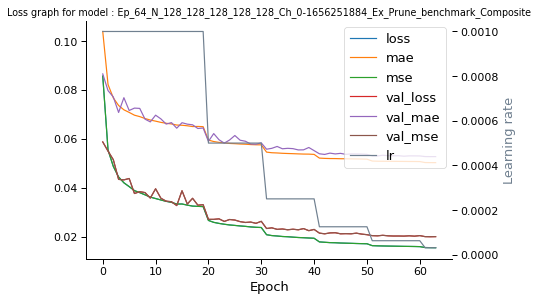

0.21145599999999987
Ep_64_N_128_128_128_128_128_Ch_0-1656251884_Ex_Prune_benchmark_Composite


<Figure size 432x288 with 0 Axes>

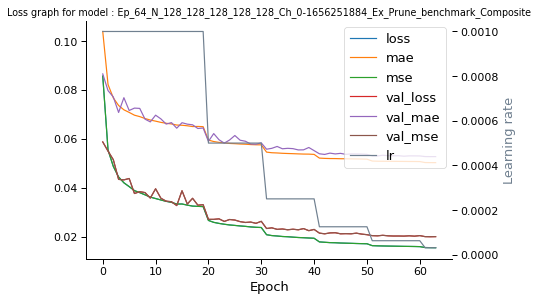

0.3094389999999998
Ep_64_N_128_128_128_128_128_Ch_0-1656251884_Ex_Prune_benchmark_Composite


<Figure size 432x288 with 0 Axes>

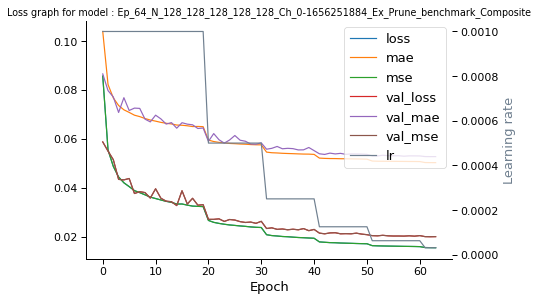

0.10886400000000007
Ep_64_N_128_128_128_128_128_Ch_0-1656251884_Ex_Prune_benchmark_Composite


<Figure size 432x288 with 0 Axes>

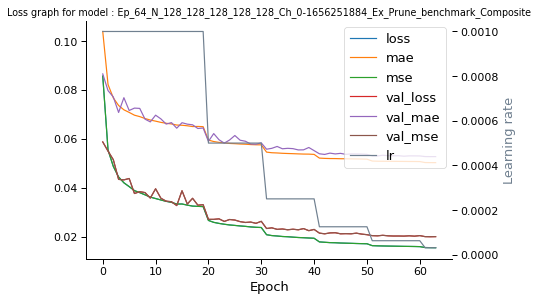

0.21145599999999987
Ep_64_N_128_128_128_128_128_Ch_0-1656251884_Ex_Prune_benchmark_Composite


<Figure size 432x288 with 0 Axes>

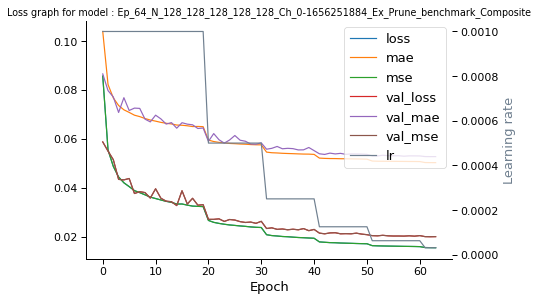

0.3094389999999998
Ep_64_N_128_128_128_128_128_Ch_0-1656251884_Ex_Prune_benchmark_Composite


<Figure size 432x288 with 0 Axes>

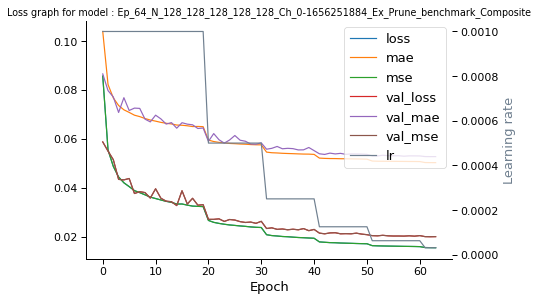

In [42]:
NN_attributes = {'Ocean' : Composite, 'Pruning' : True, 'Extra_n' : 'Prune_benchmark_Composite'}
ps = Trainings.Get_model_path_json(**NN_attributes, return_all = True)
for p in ps:
    plt.figure()
    Config = Trainings.Get_model_attributes(p)
    att = {'Ocean' : OcT, 'Uniq_id' : Config['Uniq_id']}
    print(Config['target_sparsity'])
    Plotting.Plot_loss_model(Second_axis=['lr'], **NN_attributes)